<a href="https://colab.research.google.com/github/nikizadehgfdl/grid_generation/blob/dev/jupynotebooks/Generate_Grid_Patches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coordinate Patch Algorithms

### helper routines and constants

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

#Constants
PI_180 = np.pi/180.
_default_Re = 6371.e3
HUGE = 1.0e30

#utility function to plot grids
def plot_mesh_in_latlon(lam, phi, stride=1, phi_color='k', lam_color='r', newfig=True, title=None):
    import matplotlib.pyplot as plt
#    import seaborn as sns; sns.set()
    if (phi.shape != lam.shape): raise Exception('Ooops: lam and phi should have same shape')
    nj,ni = lam.shape
    if(newfig):
        plt.figure(figsize=(10,10))
    for i in range(0,ni,stride):
        plt.plot(lam[:,i],phi[:,i],lam_color)
    for j in range(0,nj,stride):
        plt.plot(lam[j,:],phi[j,:],phi_color)
    if title is not None:
        plt.title(title)
#    plt.show()

def plot_mesh_in_xyz(lam, phi, stride=1, phi_color='k', lam_color='r', lowerlat=None, upperlat=None, newfig=True, title=None):
    if lowerlat is not None:
        lam,phi = cut_below(lam,phi,lowerlat=lowerlat)
    if upperlat is not None:
        lam,phi = cut_above(lam,phi,upperlat=upperlat)
    x = np.cos(phi*PI_180) * np.cos(lam*PI_180)
    y = np.cos(phi*PI_180) * np.sin(lam*PI_180)
    z = np.sin(phi*PI_180)
    plot_mesh_in_latlon(x, y, stride=stride, phi_color=phi_color, lam_color=lam_color, newfig=newfig, title=title)

def cut_below(lam,phi,lowerlat):
    nj,ni = lam.shape
    for j in range(0,nj):
        if(phi[j,0]>lowerlat):
            break
    jmin=j
#    print("jmin",jmin)
    return lam[jmin:,:], phi[jmin:,:]

def cut_above(lam,phi,upperlat):
    nj,ni = lam.shape
    for j in range(0,nj):
        if(phi[j,0]>upperlat):
            break
    jmax=j
#    print("jmax",jmax)
    return lam[0:jmax,:], phi[0:jmax,:]


In [0]:
def mdist(x1,x2):
  """Returns positive distance modulo 360."""
  return np.minimum( np.mod(x1-x2,360.), np.mod(x2-x1,360.) )

def generate_grid_metrics_MIDAS(x,y,axis_units='degrees',Re=_default_Re, latlon_areafix=True):
    nytot,nxtot = x.shape
    if  axis_units == 'm':
      metric=1.0
    if  axis_units == 'km':
      metric=1.e3
    if  axis_units == 'degrees':
      metric=Re*PI_180
    lv = ( 0.5 * ( y[:,1:] + y[:,:-1] ) ) * PI_180
    dx_i = mdist( x[:,1:], x[:,:-1] ) * PI_180
    dy_i = ( y[:,1:] - y[:,:-1] ) * PI_180
    dx = Re * np.sqrt( dy_i**2 + (dx_i*np.cos(lv))**2 )
    lu = ( 0.5 * ( y[1:,:] + y[:-1,:] ) ) * PI_180
    dx_j = mdist( x[1:,:], x[:-1,:] ) * PI_180
    dy_j = ( y[1:,:] - y[:-1,:] ) * PI_180
    dy = Re * np.sqrt( dy_j**2 + (dx_j*np.cos(lu))**2 )

    ymid_j = 0.5*(y+np.roll(y,shift=-1,axis=0))
    ymid_i = 0.5*(y+np.roll(y,shift=-1,axis=1))
    dy_j = np.roll(y,shift=-1,axis=0) - y
    dy_i = np.roll(y,shift=-1,axis=1) - y
    dx_i = mdist(np.roll(x,shift=-1,axis=1),x)
    dx_j = mdist(np.roll(x,shift=-1,axis=0),x)
    if(latlon_areafix):
        sl = np.sin( lv )
        dx_i = mdist( x[:,1:], x[:,:-1] ) * PI_180
        area = (Re**2) * (
            ( 0.5 * ( dx_i[1:,:] + dx_i[:-1,:] ) ) * ( sl[1:,:] - sl[:-1,:] ) )
    else:
        area = 0.25 * ( ( dx[1:,:] + dx[:-1,:] ) * ( dy[:,1:] + dy[:,:-1] ) )
    return dx,dy,area

def angle_x(x,y):
    """Returns the orientation angle of the grid box"""
    if x.shape != y.shape:
        raise Exception('Input arrays do not have the same shape!')
    angle_dx=np.zeros(x.shape)
    # The corrected version of angle_dx, in addition to including spherical metrics, is centered in the interior and one-sided at the grid edges
    angle_dx[:,1:-1] = np.arctan2(y[:,2:]-y[:,:-2],(x[:,2:]-x[:,:-2])*np.cos(y[:,1:-1]*PI_180))
    angle_dx[:,0]    = np.arctan2(y[:,1] -y[:,0]  ,(x[:,1] -x[:,0]  )*np.cos(y[:,0]*PI_180))
    angle_dx[:,-1]   = np.arctan2(y[:,-1]-y[:,-2] ,(x[:,-1]-x[:,-2] )*np.cos(y[:,-1]*PI_180))
    angle_dx = angle_dx /PI_180
    return angle_dx

def metrics_error(dx_,dy_,area_,Ni,lat1,lat2=90,Re=_default_Re,bipolar=False,displaced_pole=-999,excluded_fraction=None):
    exact_area = 2*np.pi*(Re**2)*np.abs(np.sin(lat2*PI_180)-np.sin(lat1*PI_180))
    exact_lat_arc_length = np.abs(lat2-lat1)*PI_180*Re
    exact_lon_arc_length = np.cos(lat1*PI_180) *2*np.pi*Re
    grid_lat_arc_length = np.sum(dy_[:,Ni//4])
    grid_lon_arc_length = np.sum(dx_[0,:])
    if(lat1>lat2):
        grid_lon_arc_length = np.sum(dx_[-1,:])
    if(bipolar):
        #length of the fold
        grid_lon_arc_length2 = np.sum(dx_[-1,:])
        #This must be 4*grid_lat_arc_length
        lon_arc2_error = 100*(grid_lon_arc_length2/4 - exact_lat_arc_length)/exact_lat_arc_length
    area_error = 100*(np.sum(area_)-exact_area)/exact_area
    lat_arc_error = 100*(grid_lat_arc_length - exact_lat_arc_length)/exact_lat_arc_length
    lon_arc_error = 100*(grid_lon_arc_length -  exact_lon_arc_length)/exact_lon_arc_length
    if(displaced_pole != -999):
        antipole=displaced_pole+Ni//2
        if(displaced_pole>Ni//2):
            antipole=displaced_pole-Ni//2
        grid_lat_arc_length = np.sum(dy_[:,displaced_pole]) + np.sum(dy_[:,antipole])
        lat_arc_error = 100*(grid_lat_arc_length - 2.*exact_lat_arc_length)/exact_lat_arc_length
    if(excluded_fraction):
        print("   Cannot estimate area and dy accuracies with excluded_fraction (doughnut)! ")
    if(bipolar):
        return area_error,lat_arc_error,lon_arc_error,lon_arc2_error
    else:
        return area_error,lat_arc_error,lon_arc_error


### Global grid parameters

In [0]:
# Specify the grid properties
# All
# Specify the desired resolution
refineR=2 #This is inverse of nominal resolution in degrees
refineS=2   # Set to 2 for supergrid
lenlon=360  # global longitude range
lon0=-300.  # Starting longitude (longitude of the Northern bipoles)
Ni = int(refineR*refineS* lenlon)

# Generating the Mercator grid

Requesting Mercator grid with phi range: phi_s,phi_n= -68.05725376601046 65.0
   y*= [-376  345] nj= 722
   Generating Mercator grid with phi range: phi_s,phi_n= [-68.05725377  64.97316302]
   Final Mercator grid range= -68.05725376601046 64.97316302279852
   number of js= 722


<Figure size 720x720 with 0 Axes>

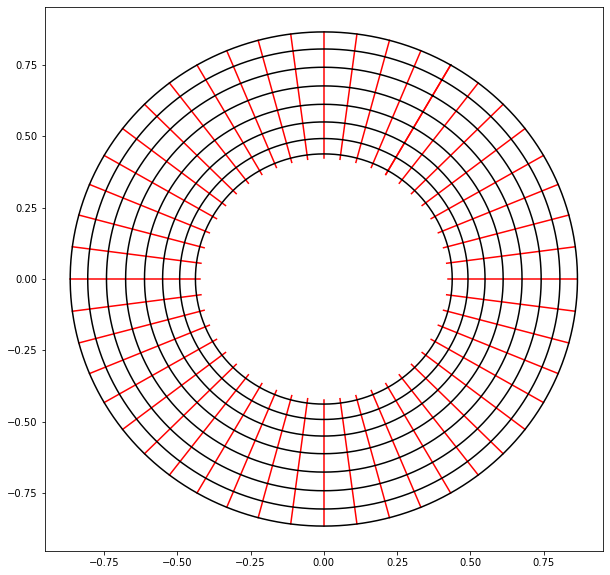

In [4]:
#Mercator grid extent requested (not necessarily exactly what you'll get)
#phi_s_Merc, phi_n_Merc = -66.85954725, 64.05895973
phi_s_Merc, phi_n_Merc = -68.05725376601046, 65.0

def y_mercator(Ni, phi):
    """Equation (1)"""
    R = Ni / (2 * np.pi)
    return R * ( np.log( (1.0 + np.sin(phi) ) / np.cos(phi)) )
def phi_mercator(Ni, y):
    """Equation (2)"""
    R = Ni / (2 * np.pi)
    return np.arctan( np.sinh(y/R) ) * (180/np.pi) # Converted to degrees
def y_mercator_rounded(Ni, phi):
    y_float = y_mercator(Ni, phi)
    return ( np.sign(y_float) * np.round_( np.abs(y_float) ) ).astype(int)

def generate_mercator_grid_lite(Ni,phi_s,phi_n,lon0_M,lenlon_M,refineR):
    print( 'Requesting Mercator grid with phi range: phi_s,phi_n=', phi_s,phi_n )
    # Diagnose nearest integer y(phi range)
    y_star = y_mercator_rounded(Ni, np.array([phi_s*PI_180,phi_n*PI_180]))
    print( '   y*=',y_star, 'nj=', y_star[1]-y_star[0]+1  )
    Nj=y_star[1]-y_star[0]
    print( '   Generating Mercator grid with phi range: phi_s,phi_n=', phi_mercator(Ni, y_star) )
    phi_M = phi_mercator(Ni, np.arange(y_star[0],y_star[1]+1))
    #Tile it
    y_grid_M = np.tile(phi_M.reshape(Nj+1,1),(1,Ni+1))
    lam_M = lon0_M + np.arange(Ni+1) * lenlon_M/float(Ni)
    x_grid_M = np.tile(lam_M,(Nj+1,1))
    print('   Final Mercator grid range=',y_grid_M[0,0],y_grid_M[-1,0])
    print('   number of js=',y_grid_M.shape[0])
    return x_grid_M,y_grid_M

lamMerc,phiMerc = generate_mercator_grid_lite(Ni,phi_s_Merc,phi_n_Merc,lon0,lenlon, refineR)

#plot grid
plt.figure(figsize=(10,10))
plot_mesh_in_xyz(lamMerc,phiMerc, stride=30,lowerlat=30)

## Metrics

In [5]:
#For spherical grids we can safely use the MIDAS algorithm for calculating the metrics
dxMerc,dyMerc,areaMerc = generate_grid_metrics_MIDAS(lamMerc,phiMerc)
print("metrics errors in estiamting (area, lat arc, lon arc) is ", metrics_error(dxMerc,dyMerc,areaMerc,Ni,phiMerc[0,0],phiMerc[-1,0]))

metrics errors in estiamting (area, lat arc, lon arc) is  (2.6729716741025974e-14, 1.25919851061012e-14, 1.2452108931836622e-14)


# Generating the Northern Bipolar grid

Generating bipolar grid bounded at latitude  65.0
   number of js= 239


<Figure size 720x720 with 0 Axes>

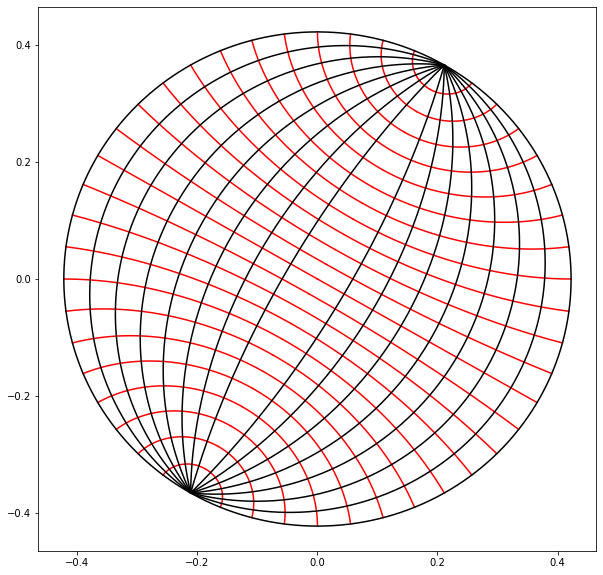

In [6]:
#Northern bipolar cap
#Nj_ncap=int(60*refineR*refineS)
Nj_ncap = 119*refineS
lon_bp=lon0 # longitude of the displaced pole(s)
lat0_bp=phi_n_Merc  #mercator.y.max()
lenlat_bp=90.0-lat0_bp
def bipolar_projection(lamg,phig,lon_bp,rp, metrics_only=False):
    """Makes a stereographic bipolar projection of the input coordinate mesh (lamg,phig)  
       Returns the projected coordinate mesh and their metric coefficients (h^-1).
       The input mesh must be a regular spherical grid capping the pole with:
           latitudes between 2*arctan(rp) and 90  degrees
           longitude between lon_bp       and lonp+360   
       """
    ### symmetry meridian resolution fix 
    phig = 90-2*np.arctan(np.tan(0.5*(90-phig)*PI_180)/rp)/PI_180
    tmp = mdist(lamg,lon_bp)*PI_180
    sinla = np.sin(tmp)  #This makes phis symmetric 
    sphig = np.sin(phig*PI_180)
    alpha2 = (np.cos(tmp))**2 #This makes dy symmetric
    beta2_inv = (np.tan(phig*PI_180))**2
    rden = 1./(1.+alpha2*beta2_inv)

    if(not metrics_only):
        B=sinla*np.sqrt(rden) #Actually two equations  +- |B|
        #Deal with beta=0
        B=np.where(np.abs(beta2_inv)>HUGE , 0.0, B)
        lamc = np.arcsin(B)/PI_180
        ##But this equation accepts 4 solutions for a given B, {l, 180-l, l+180, 360-l } 
        ##We have to pickup the "correct" root. 
        ##One way is simply to demand lamc to be continuous with lam on the equator phi=0
        ##I am sure there is a more mathematically concrete way to do this.
        lamc = np.where((lamg-lon_bp>90)&(lamg-lon_bp<=180),180-lamc,lamc)
        lamc = np.where((lamg-lon_bp>180)&(lamg-lon_bp<=270),180+lamc,lamc)
        lamc = np.where((lamg-lon_bp>270),360-lamc,lamc)
        #Along symmetry meridian choose lamc
        lamc = np.where((lamg-lon_bp==90),90,lamc)    #Along symmetry meridian choose lamc=90-lon_bp
        lamc = np.where((lamg-lon_bp==270),270,lamc)  #Along symmetry meridian choose lamc=270-lon_bp    
        lams = lamc + lon_bp

    ##Project back onto the larger (true) sphere so that the projected equator shrinks to latitude \phi_P=lat0_tp
    ##then we have tan(\phi_s'/2)=tan(\phi_p'/2)tan(\phi_c'/2)
    A=sinla*sphig
    chic = np.arccos(A)
    phis = 90 - 2 * np.arctan(rp * np.tan(chic/2))/PI_180
    ##Calculate the Metrics
    rden2 = 1. / (1 + (rp*np.tan(chic/2))**2)
    M_inv = rp * (1 + (np.tan(chic/2))**2) * rden2
    M = 1/M_inv
    chig = (90-phig)*PI_180
    rden2 = 1. / (1 + (rp*np.tan(chig/2))**2)
    N     = rp * (1 + (np.tan(chig/2))**2) * rden2
    N_inv = 1/N
    cos2phis = (np.cos(phis*PI_180))**2

    h_j_inv = cos2phis*alpha2*(1-alpha2)*beta2_inv*(1+beta2_inv) * (rden**2) \
            +  M_inv*M_inv*(1-alpha2) * rden
    #Deal with beta=0. Prove that cos2phis/alpha2 ---> 0 when alpha, beta  ---> 0
    h_j_inv=np.where(np.abs(beta2_inv)>HUGE , M_inv*M_inv, h_j_inv)
    h_j_inv = np.sqrt(h_j_inv)*N_inv

    h_i_inv = cos2phis * (1+beta2_inv) * (rden**2) + M_inv*M_inv*alpha2*beta2_inv * rden
    #Deal with beta=0
    h_i_inv=np.where(np.abs(beta2_inv)>HUGE , M_inv*M_inv, h_i_inv)
    h_i_inv = np.sqrt(h_i_inv)

    if(not metrics_only):
        return lams,phis,h_i_inv,h_j_inv
    else:
        return h_i_inv,h_j_inv


def generate_bipolar_cap_mesh(Ni,Nj_ncap,lat0_bp,lon_bp):
    #Define a (lon,lat) coordinate mesh on the Northern hemisphere of the globe sphere
    #such that the resolution of latg matches the desired resolution of the final grid along the symmetry meridian 
    print( 'Generating bipolar grid bounded at latitude ',lat0_bp  )
    lon_g = lon_bp  + np.arange(Ni+1) *  360./float(Ni)
    lamg = np.tile(lon_g,(Nj_ncap+1,1))
    latg0_cap = lat0_bp + np.arange(Nj_ncap+1) * (90-lat0_bp)/float(Nj_ncap)
    phig = np.tile(latg0_cap.reshape((Nj_ncap+1,1)),(1,Ni+1))
    rp=np.tan(0.5*(90-lat0_bp)*PI_180)
    lams,phis,h_i_inv,h_j_inv = bipolar_projection(lamg,phig,lon_bp,rp)
    h_i_inv = h_i_inv[:,:-1] * 2*np.pi/float(Ni)
    h_j_inv = h_j_inv[:-1,:] * PI_180*(90-lat0_bp)/float(Nj_ncap)
    print('   number of js=',phis.shape[0])
    return lams,phis,h_i_inv,h_j_inv


lamBP,phiBP,dxBP_h,dyBP_h = generate_bipolar_cap_mesh(Ni,Nj_ncap,lat0_bp,lon_bp)
#plot grid
plt.figure(figsize=(10,10))
plot_mesh_in_xyz(lamBP,phiBP, stride=30,lowerlat=30)

In [7]:
def bipolar_cap_ij_array(i,j,Ni,Nj_ncap,lat0_bp,lon_bp,rp):
    long = lon_bp  + i * 360./float(Ni)
    latg = lat0_bp + j * (90-lat0_bp)/float(Nj_ncap)
    lamg = np.tile(long,(latg.shape[0],1))
    phig = np.tile(latg.reshape((latg.shape[0],1)),(1,long.shape[0]))
    h_i_inv,h_j_inv = bipolar_projection(lamg,phig,lon_bp,rp,metrics_only=True)
    h_i_inv = h_i_inv * 2*np.pi/float(Ni)
    h_j_inv = h_j_inv * (90-lat0_bp)*PI_180/float(Nj_ncap)
    return h_i_inv,h_j_inv


def bipolar_cap_metrics_quad_fast(order,nx,ny,lat0_bp,lon_bp,rp,Re=_default_Re):
    print("   Calculating bipolar cap metrics via quadrature ...")
    a,b = quad_positions(order)
    daq = np.zeros([ny+1,nx+1])
    dxq = np.zeros([ny+1,nx+1])
    dyq = np.zeros([ny+1,nx+1])

    j1d = np.empty([0])
    for j in range(0,ny+1):
        j_s = b*j + a*(j+1)
        if(j_s[-1]==ny): j_s[-1]=ny-0.001 #avoid phi=90 as this will cause errore. 
                                          #Niki:Find a way to avoid this properly. 
                                          #This could be a sign that there is still something  
                                          #wrong with the h_j_inv calculations at phi=90 (beta=0).
        j1d = np.append(j1d,j_s)

    i1d = np.empty([0])
    for i in range(0,nx+1):
        i_s = b*i + a*(i+1)
        i1d = np.append(i1d,i_s)

    #dx,dy = bipolar_cap_ij_array(i1d,j1d,nx,ny,lat0_bp,lon_bp,rp)
    #Or to make it faster:
    nj,ni = j1d.shape[0],i1d.shape[0] # Shape of results
    dj = min(nj, max(32*1024//ni,1)) # Stride to use that fits in memory
    lams,phis,dx,dy = np.zeros((nj,ni)),np.zeros((nj,ni)),np.zeros((nj,ni)),np.zeros((nj,ni))
    for j in range(0,nj,dj):
        je = min(nj,j+dj)
        dx[j:je],dy[j:je] = bipolar_cap_ij_array(i1d,j1d[j:je],nx,ny,lat0_bp,lon_bp,rp)

    #reshape to send for quad averaging
    dx_r = dx.reshape(ny+1,order,nx+1,order)
    dy_r = dy.reshape(ny+1,order,nx+1,order)
    #area element
    dxdy_r = dx_r*dy_r

    for j in range(0,ny+1):
        for i in range(0,nx+1):
            daq[j,i] = quad_average_2d(dxdy_r[j,:,i,:])
            dxq[j,i] = quad_average(dx_r[j,0,i,:])
            dyq[j,i] = quad_average(dy_r[j,:,i,0])
    daq = daq[:-1,:-1]*Re*Re
    dxq = dxq[:,:-1]  *Re
    dyq = dyq[:-1,:]  *Re
    return dxq,dyq,daq

def quad_positions(n=3):
    """Returns weights wa and wb so that the element [xa,xb] is sampled at positions
    x=wa(xa+xb*xb)."""
    if n==2:
        return np.array([0.,1.]),np.array([1.,0.])
    if n==3:
        return np.array([0.,0.5,1.]),np.array([1.,0.5,0.])
    if n==4:
        r5 = 0.5 / np.sqrt(5.)
        return np.array([0.,0.5-r5,0.5+r5,1.]),np.array([1.,0.5+r5,0.5-r5,0.])
    if n==5:
        r37 = 0.5 * np.sqrt(3./7.)
        return np.array([0.,0.5-r37,0.5,0.5+r37,1.]),np.array([1.,0.5+r37,0.5,0.5-r37,0.])
    raise Exception('Uncoded order')

def quad_average(y):
    """Returns the average value found by quadrature at order n.
    y is a list of values in order from x=-1 to x=1."""
    if len(y)==2: # 1, 1
        d = 1./2.
        return d * ( y[0] + y[1] )
    if len(y)==3: # 1/3, 4/3, 1/3
        d = 1./6.
        return d * ( 4. * y[1] + ( y[0] + y[2] ) )
    if len(y)==4: # 1/6, 5/6, 5/6, 1/6
        d = 1. / 12.
        return d * ( 5. * ( y[1] + y[2] ) + ( y[0] + y[3] ) )
    if len(y)==5: # 9/10, 49/90, 64/90, 49/90, 9/90
        d = 1. / 180.
        return d * ( 64.* y[2] + ( 49. * ( y[1] + y[3] ) )  + 9. * ( y[0] + y[4] ) )
    raise Exception('Uncoded order')

def quad_average_2d(y):
    """Returns the average value found by quadrature at order n.
    y is a list of values in order from x1=-1 to x1=1 and x2=-1 to x2=1."""
    if y.shape[0] != y.shape[1]:
        raise Exception('Input array is not squared!')
    
    if y.shape[0]==2: # 1, 1
        d = 1./2.
        return d * d * ( y[0,0] + y[0,1] + y[1,0] + y[1,1] )
    if y.shape[0]==3: # 1/3, 4/3, 1/3
        d = 1./6.
        return d * d * ( y[0,0]+y[0,2]+y[2,0]+y[2,2] +4.*(y[0,1]+y[1,0]+y[1,2]+y[2,1] + 4.*y[1,1]))
    if y.shape[0]==4: # 1/6, 5/6, 5/6, 1/6
        d = 1. / 12.
#       return d * ( 5. * ( y[1] + y[2] ) + ( y[0] + y[3] ) )
        w = np.array([1.,5.,5.,1.])
        ysum=0.
        for j in range(0,y.shape[0]):
            for i in range(0,y.shape[1]):
                ysum = ysum+ w[i]*w[j]*y[j,i]
        return d * d * ysum
    if y.shape[0]==5: # 9/10, 49/90, 64/90, 49/90, 9/90
        d = 1. / 180.
        #return d * ( 64.* y[2] + ( 49. * ( y[1] + y[3] ) )  + 9. * ( y[0] + y[4] ) )
        w = np.array([9.,49.,64.,49.,9.])
        ysum=0.
        for j in range(0,y.shape[0]):
            for i in range(0,y.shape[1]):
                ysum = ysum+ w[i]*w[j]*y[j,i]
        return d * d * ysum

    raise Exception('Uncoded order')

rp=np.tan(0.5*(90-lat0_bp)*PI_180)
dxBP,dyBP,areaBP = bipolar_cap_metrics_quad_fast(5,phiBP.shape[1]-1,phiBP.shape[0]-1,lat0_bp,lon_bp,rp)
print("metrics errors in estiamting (area, lat arc, lon arc1, lon arc2) is", metrics_error(dxBP,dyBP,areaBP,Ni,lat0_bp,90.,bipolar=True))


   Calculating bipolar cap metrics via quadrature ...
metrics errors in estiamting (area, lat arc, lon arc1, lon arc2) is (-1.8636583977587627e-12, 1.6751170268631178e-14, -4.404071734365795e-14, -1.6751170268631178e-14)


# Generating the Spherical Southern Ocean grid

Generating regular lat-lon grid between latitudes  -78.0 -68.05725376601046
   generated regular lat-lon grid between latitudes  -78.0 -68.05725376601046
   number of js= 109
metrics errors in estiamting (area, lat arc, lon arc) is  (0.0, 0.0, 2.238018859880336e-14)


<Figure size 720x720 with 0 Axes>

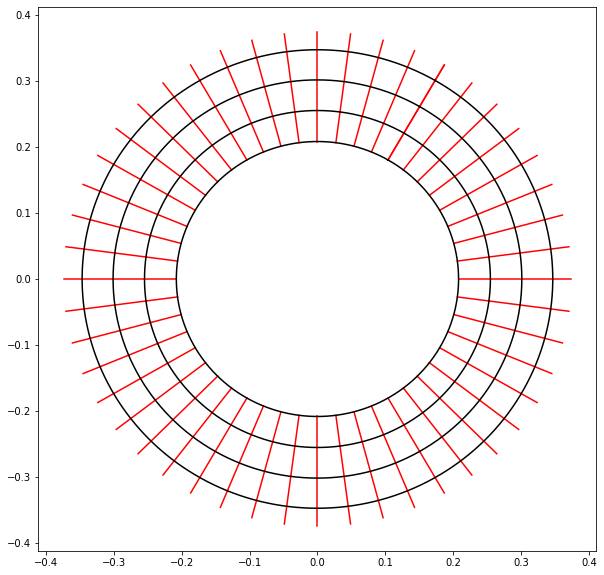

In [8]:
#Southern grid
#Nj_SO  =int(refineR*  55)
Nj_SO=54*refineS
lat0_SO=-78.0
lenlat_SO = phi_s_Merc-lat0_SO 
deltaPhiSO = 1.0/refineR/refineS

def generate_latlon_grid(lni,lnj,llon0,llen_lon,llat0,llen_lat, ensure_nj_even=True):
    print('Generating regular lat-lon grid between latitudes ', llat0, llat0+llen_lat)
    llonSP = llon0 + np.arange(lni+1) * llen_lon/float(lni)
    llatSP = llat0 + np.arange(lnj+1) * llen_lat/float(lnj)
    if(llatSP.shape[0]%2 == 0 and ensure_nj_even):
        print("   The number of j's is not even. Fixing this by cutting one row at south.")
        llatSP = np.delete(llatSP,0,0)

    llamSP = np.tile(llonSP,(llatSP.shape[0],1))
    lphiSP = np.tile(llatSP.reshape((llatSP.shape[0],1)),(1,llonSP.shape[0]))

    print('   generated regular lat-lon grid between latitudes ', lphiSP[0,0],lphiSP[-1,0])
    print('   number of js=',lphiSP.shape[0])
    return llamSP,lphiSP

lamSO,phiSO = generate_latlon_grid(Ni,Nj_SO,lon0,lenlon,lat0_SO,lenlat_SO)
dxSO,dySO,areaSO = generate_grid_metrics_MIDAS(lamSO,phiSO)
print("metrics errors in estiamting (area, lat arc, lon arc) is ", metrics_error(dxSO,dySO,areaSO,Ni,phiSO[0,0],phiSO[-1,0]))

#plot grid
plt.figure(figsize=(10,10))
plot_mesh_in_xyz(lamSO,phiSO, stride=30,lowerlat=-80)

# Generating a Displaced Pole grid

In [9]:
#Southern cap
Nj_scap = int(refineR *  40)
Nj_scap = Nj_scap *7//4
lon_dp=80.0   # longitude of the displaced pole 
lat0_SC=lat0_SO
r_dp=0.20

def displacedPoleCap_projection(lon_grid,lat_grid,z_0,r_joint):
    r = np.tan((90+lat_grid) *PI_180)/r_joint
    #Find the theta that has matching resolution at the unit circle with longitude at the joint
    #This is a conformal transformation of the unit circle (inverse to the one below)
    e2itheta = np.cos(lon_grid*PI_180) + 1j*np.sin(lon_grid*PI_180)
    e2ithetaprime = (e2itheta - z_0)/(1. - np.conj(z_0)*e2itheta)
    #Conformal map to displace pole from r=0 to r=r_dispole
    z=r*e2ithetaprime
    w=(z+z_0)/(1+np.conj(z_0)*z)
    #Inverse projection from tangent plane back to sphere
    lamcDP = np.angle(w, deg=True)
    #lamcDP = np.arctan2(np.imag(w), np.real(w))/PI_180
    #np.angle returns a value in the interval (-180,180)
    #However the input grid longitude is in (-lon0,-lon0+360), e.g., (-300,60)
    #We should shift the angle to be in that interval
    ##But we should also be careful to produce a monotonically increasing longitude, starting from lon0.
    lamcDP = monotonic_bounding(lamcDP,lon_grid[0,0])
    #
    rw=np.absolute(w)
    phicDP = -90+np.arctan(rw*r_joint)/PI_180
    return lamcDP,phicDP

def monotonic_bounding(x,x_0):
    x_im1= x[:,0]*0 + x_0 #Initial value
    for i in range(0,x.shape[1]):
        x[:,i]=np.where(x[:,i]-x_im1[:] > 100, x[:,i]-360, x[:,i])
        x_im1[:] = x[:,i]
    return x

def displacedPoleCap_baseGrid(i,j,ni,nj,lon0,lat0):
    u = lon0  + i * 360./float(ni)
    a=-90.
    b=lat0
    v=a + j * (b-a)/float(nj)
    du=np.roll(u,shift=-1,axis=0)-u
    dv=np.roll(v,shift=-1,axis=0)-v
    return u,v,du,dv

def displacedPoleCap_mesh(i,j,ni,nj,lon0,lat0,lam_pole,r_pole,excluded_fraction=None):

    long,latg,du,dv = displacedPoleCap_baseGrid(i,j,ni,nj,lon0,lat0)
    lamg = np.tile(long,(latg.shape[0],1))
    phig = np.tile(latg.reshape((latg.shape[0],1)),(1,long.shape[0]))
    #Projection from center of globe to plane tangent at south pole
    r_joint = np.tan((90+lat0)*PI_180)
    z_0= r_pole * (np.cos(lam_pole*PI_180)+1j*np.sin(lam_pole*PI_180))
    lams,phis = displacedPoleCap_projection(lamg,phig,z_0,r_joint)

    if excluded_fraction is not None:
        ny,nx = lamg.shape
        jmin=np.ceil(excluded_fraction*ny)
        jmin=jmin+np.mod(jmin,2)
        jmint = int(jmin)
        return lams[jmint:,:], phis[jmint:,:]
    else:
        return lams,phis

def generate_displaced_pole_grid(Ni,Nj_scap,lon0,lat0,lon_dp,r_dp):
    print( 'Generating displaced pole grid bounded at latitude ',lat0  )
    print('   rdp=',r_dp)
    i_s=np.arange(Ni+1)
    j_s=np.arange(Nj_scap+1)
    x,y= displacedPoleCap_mesh(i_s,j_s,Ni,Nj_scap,lon0,lat0,lon_dp,r_dp)
    return x,y

lamSC,phiSC = generate_displaced_pole_grid(Ni,Nj_scap,lon0,lat0_SC,lon_dp,r_dp)

#plot grid
#plt.figure(figsize=(10,10))
#plot_mesh_in_xyz(lamSC,phiSC, stride=30,lowerlat=-90)

Generating displaced pole grid bounded at latitude  -78.0
   rdp= 0.2


In [0]:
def displacedPoleCap_plot(x_s,y_s,lon0,lon_dp,lat0_SO, stride=40,block=False):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,10))
    x_s=x_s+lon0
    plot_mesh_in_xyz(x_s,y_s, stride=stride, newfig=False)
    lam__ = x_s[-1,0]
    phi__ = y_s[-1,0]
    x__ = np.cos(phi__*PI_180) * np.cos(lam__*PI_180)
    y__ = np.cos(phi__*PI_180) * np.sin(lam__*PI_180)
    plt.annotate("i=0",xy=(x__,y__), xytext=(x__-0.01,y__+0.01),arrowprops=dict(arrowstyle="->"))

    #plot the location of the displaced pole
    lam__=np.array([lon_dp,lon_dp])+lon0
    phi__=np.array([lat0_SO+2,lat0_SO-2])
    x__ = np.cos(phi__*PI_180) * np.cos(lam__*PI_180)
    y__ = np.cos(phi__*PI_180) * np.sin(lam__*PI_180)
    plt.plot(x__,y__, linestyle='dashed')
    plt.annotate("pole's lon",xy=(x__[0],y__[0]), xytext=(x__[0],y__[0]+0.01),arrowprops=dict(arrowstyle="->"))

    n_i=x_s.shape[1]-1
    poles_i=int(n_i*np.mod(lon_dp-lon0,360)/360.)
    lam__=x_s[:,poles_i]
    phi__=y_s[:,poles_i]
    x__ = np.cos(phi__*PI_180) * np.cos(lam__*PI_180)
    y__ = np.cos(phi__*PI_180) * np.sin(lam__*PI_180)
    plt.plot(x__,y__,linewidth=4, color='green')

    antipoles_i=int(n_i*np.mod(180+lon_dp-lon0,360)/360.)
    lam__=x_s[:,antipoles_i]
    phi__=y_s[:,antipoles_i]
    x__ = np.cos(phi__*PI_180) * np.cos(lam__*PI_180)
    y__ = np.cos(phi__*PI_180) * np.sin(lam__*PI_180)
    plt.plot(x__,y__,linewidth=4, color='blue')
    plt.show(block)

def displacedPoleCap_plot2(x_s,y_s,lon0,lon_dp,lat0, stride=40,block=False):
    from mpl_toolkits.basemap import Basemap
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 10))
    m = Basemap(projection='spstere',boundinglat=-60,lon_0=300,resolution='l')
    m.drawcoastlines()
    m.fillcontinents(color='coral',lake_color='aqua')
    m.drawparallels(np.arange(lat0,0.,10.),labels=[True,True])
    m.drawmeridians(np.arange(0.,360.,20.),labels=[True,True,True,True])
    m.drawmeridians(np.arange(lon_dp,lon_dp+1,1.),labels=[True,True,True,True],color='r',linewidth=4)
    m.drawmapboundary(fill_color='aqua')

    x, y = m(x_s[::2,::80],y_s[::2,::80])
    plt.plot(x, y, 'ok', markersize=2)
    plt.show(block)


The geographical location of the displaced pole= 80.0 -87.56574691920382


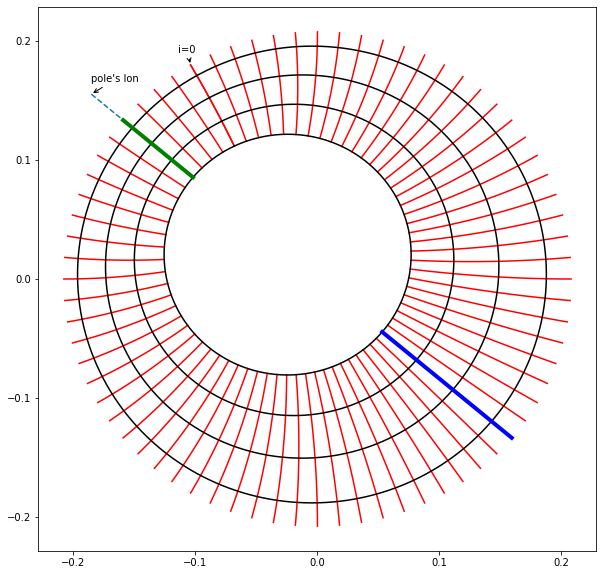

In [11]:
doughnut = 0.28 *7/4
lat_dp = -90 + np.arctan(r_dp*np.tan((90+lat0_SC)*np.pi/180))*180/np.pi
print("The geographical location of the displaced pole=",lon_dp,lat_dp)

if(doughnut != 0.0):
    jmin=np.ceil(doughnut*Nj_scap)
    jmin=jmin+np.mod(jmin,2)
    jmint = int(jmin)
    lamSC = lamSC[jmint:,:]
    phiSC = phiSC[jmint:,:]
    
displacedPoleCap_plot (lamSC,phiSC,lon0,lon_dp,lat0_SO, stride=int(refineR*10),block=True)
#displacedPoleCap_plot2(lamSC,phiSC,lon0,lon_dp,lat0_SO, stride=int(refineR*10),block=True)

In [12]:
#numerical approximation of metrics coefficients h_i and h_j
def great_arc_distance(j0, i0, j1, i1, nx,ny ,lon0,lat0,lon_dp,r_dp):
    """Returns great arc distance between nodes (j0,i0) and (j1,i1)"""
    # https://en.wikipedia.org/wiki/Great-circle_distance
    lam0,phi0= displacedPoleCap_mesh(i0,j0, nx,ny,lon0,lat0,lon_dp,r_dp)
    lam1,phi1= displacedPoleCap_mesh(i1,j1, nx,ny,lon0,lat0,lon_dp,r_dp)
    lam0,phi0=lam0*PI_180,phi0*PI_180
    lam1,phi1=lam1*PI_180,phi1*PI_180
    dphi, dlam = phi1 - phi0, lam1 - lam0
    # Haversine formula
    d = np.sin( 0.5 * dphi)**2 + np.sin( 0.5 * dlam)**2 * np.cos(phi0) * np.cos(phi1)
    return 2. * np.arcsin( np.sqrt( d ) )

def numerical_hi(j, i, nx,ny ,lon0,lat0,lon_dp,r_dp, eps, order=6):
    """Returns a numerical approximation to h_lambda"""
    reps = 1. / eps
    ds2 = great_arc_distance(j, i+eps, j, i-eps, nx,ny ,lon0,lat0,lon_dp,r_dp)
    if order == 2: return 0.5 * ds2 * reps
    ds4 = great_arc_distance(j, i+2.*eps, j, i-2.*eps, nx,ny ,lon0,lat0,lon_dp,r_dp)
    if order == 4: return ( 8. * ds2 - ds4 ) * (1./12.) * reps
    ds6 = great_arc_distance(j, i+3.*eps, j, i-3.*eps, nx,ny ,lon0,lat0,lon_dp,r_dp)
    if order == 6: return ( 45. * ds2 - 9. * ds4 + ds6 ) * (1./60.) * reps
    raise Exception('order not coded')

def numerical_hj(j, i, nx,ny ,lon0,lat0,lon_dp,r_dp, eps, order=6):
    """Returns a numerical approximation to h_phi"""
    reps = 1. / eps
    ds2 = great_arc_distance(j+eps, i, j-eps, i, nx,ny ,lon0,lat0,lon_dp,r_dp)
    if order == 2: return 0.5 * ds2 * reps
    ds4 = great_arc_distance(j+2.*eps, i, j-2.*eps, i, nx,ny ,lon0,lat0,lon_dp,r_dp)
    if order == 4: return ( 8. * ds2 - ds4 ) * (1./12.) * reps
    ds6 = great_arc_distance(j+3.*eps, i, j-3.*eps, i, nx,ny ,lon0,lat0,lon_dp,r_dp)
    if order == 6: return ( 45. * ds2 - 9. * ds4 + ds6 ) * (1./60.) * reps
    raise Exception('order not coded')


def displacedPoleCap_metrics_quad(order,nx,ny,lon0,lat0,lon_dp,r_dp,Re=_default_Re):
    print("   Calculating displaced pole cap metrics via quadrature ...")
    a,b = quad_positions(order)
    #Note that we need to include the index of the last point of the grid to do the quadrature correctly.
    daq = np.zeros([ny+1,nx+1])
    dxq = np.zeros([ny+1,nx+1])
    dyq = np.zeros([ny+1,nx+1])

    j1d = np.empty([0])
    for j in range(0,ny+1):
        j_s = b*j + a*(j+1)
        j1d = np.append(j1d,j_s)

    i1d = np.empty([0])
    for i in range(0,nx+1):
        i_s = b*i + a*(i+1)
        i1d = np.append(i1d,i_s)
    #numerical approximation to h_i_in and h_j_inv at quadrature points
    dx = numerical_hi(j1d, i1d, nx,ny ,lon0,lat0,lon_dp,r_dp, eps=1e-3, order=order)
    dy = numerical_hj(j1d, i1d, nx,ny ,lon0,lat0,lon_dp,r_dp, eps=1e-3, order=order)
    #reshape to send for quad averaging
    dx_r = dx.reshape(ny+1,order,nx+1,order)
    dy_r = dy.reshape(ny+1,order,nx+1,order)
    #area element
    dxdy_r = dx_r*dy_r

    for j in range(0,ny+1):
        for i in range(0,nx+1):
            daq[j,i] = quad_average_2d(dxdy_r[j,:,i,:])
            dxq[j,i] = quad_average(dx_r[j,0,i,:])
            dyq[j,i] = quad_average(dy_r[j,:,i,0])

    daq = daq[:-1,:-1]*Re*Re
    dxq = dxq[:,:-1]  *Re
    dyq = dyq[:-1,:]  *Re

    return dxq,dyq,daq

dxSC,dySC,areaSC = displacedPoleCap_metrics_quad(4,Ni,Nj_scap,lon0,lat0_SC,lon_dp,r_dp)
poles_i=int(Ni*np.mod(lon_dp-lon0,360)/360.)
print("metrics errors in estiamting (area, lat arc, lon arc) is ", metrics_error(dxSC,dySC,areaSC,Ni,lat1=lat0_SC, lat2=-90.,displaced_pole=poles_i,excluded_fraction=doughnut))

   Calculating displaced pole cap metrics via quadrature ...
   Cannot estimate area and dy accuracies with excluded_fraction (doughnut)! 
metrics errors in estiamting (area, lat arc, lon arc) is  (0.00016257341247925117, 1.2787424603816325e-09, -1.2119543531909984e-09)
